In [ ]:
#| default_exp activations

In [ ]:
! pip install ..

In [ ]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.learner import *

In [ ]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset


from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [ ]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
name = "fashion_mnist"
bs = 1024

@inplace
def transformi(b): b['image'] = [TF.to_tensor(o) for o in b['image']]

datasetdict = load_dataset(name).with_transform(transformi)
dls = DataLoaders.from_dd(datasetdict, bs, num_workers=4)
train_dl = dls.train

In [ ]:
train_dl

In [22]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2,
                    kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn():
    return nn.Sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten())

In [23]:
from torcheval.metrics import MulticlassAccuracy

In [24]:
metrics = MetricsCB(accuracy = MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [25]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,state
0.161,2.301,0,train
0.354,2.144,0,eval


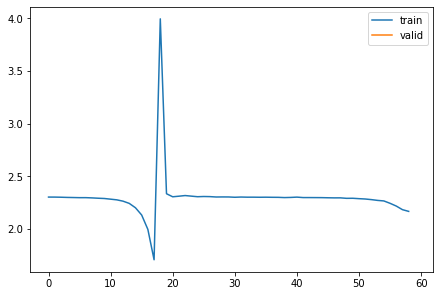

In [29]:
set_seed(1)
learn = fit(cnn())

In [ ]:
set_seed(1)
# okay so the network would have learned... he just sabotauged it on purpose to
# demonstrate bad activations.
learn = fit(cnn(), epochs = 20)

## Manual hooks
to do manual hooks: write a sequential model containing the module list,
during forward call, call each module in a loop and save the activations,
their means / std deviations etc.

## pytorch hooks

In [123]:
model = cnn()
act_means = [[] for _ in model]
'''
note: if you do 
act_means = [[]] * len(model)
it will seem to work but all lists will share the same memory
'''
act_stds  = [[] for _ in model]


In [124]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds[i].append(to_cpu(outp).std())

In [125]:
# note: if you run this cell a bunch of times, it will register
# a bunch of redundant forward hooks and keep the old ones
for i,m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [ ]:
fit(model, epochs=25)

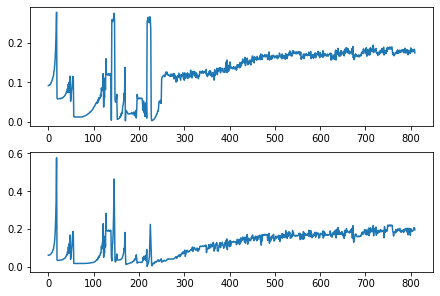

In [127]:
fig,axs = plt.subplots(2)
axs[0].plot(act_means[0])
axs[1].plot(act_means[1])

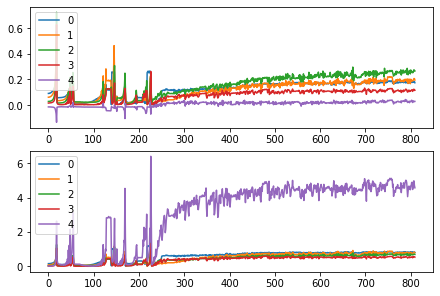

In [132]:
fig,axs = plt.subplots(2)
for i in range(5):
    axs[0].plot(act_means[i])
    axs[1].plot(act_stds[i])
axs[0].legend(range(5))
axs[1].legend(range(5))

In [133]:
#| export
class Hook():
    def __init__(self, model, f):
        self.hook = model.register_forward_hook(partial(f, self))

    def remove(self):
        self.hook.remove()
    
    def __del__(self):
        self.remove()


In [134]:
def append_stats(hook, model, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [])
    
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [135]:
model=cnn()

In [137]:
hooks = [Hook(layer, append_stats)
         for layer in model[:5].children()]

In [148]:
model,'lol\n',list(model[:5].children())

(Sequential(
   (0): Sequential(
     (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
     (1): ReLU()
   )
   (1): Sequential(
     (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
   )
   (2): Sequential(
     (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
   )
   (3): Sequential(
     (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ReLU()
   )
   (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (5): Flatten(start_dim=1, end_dim=-1)
 ),
 'lol\n',
 [Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  ),
  Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  ),
  Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  ),
  Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stri

In [150]:
len(hooks)

5

accuracy,loss,epoch,state
0.170,2.276,0,train
0.254,1.935,0,eval
0.152,2.261,1,train
0.406,2.025,1,eval
0.529,1.271,2,train
0.646,0.895,2,eval
0.705,0.772,3,train
0.722,0.711,3,eval
0.764,0.626,4,train
0.781,0.580,4,eval


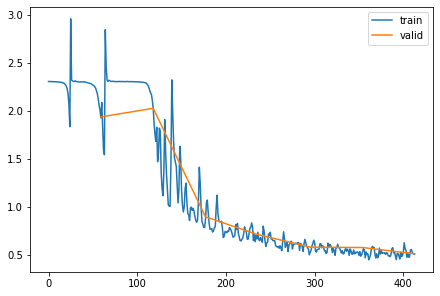

In [151]:
learn = fit(model, epochs=7)

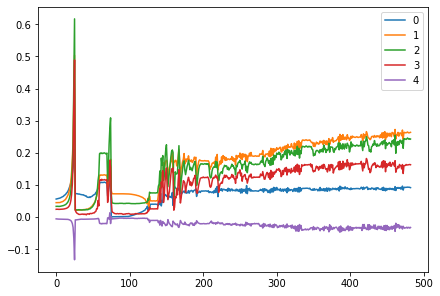

In [152]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5))

In [153]:
#| export
class Hooks(list):
    def __init__(self, models, f):
        super().__init__(
            [Hook(m, f) for m in models]
        )
        
    def __enter__(self,*args):
        return self
    
    def __exit__(self, *args):
        self.remove()
        
    def __del__(self):
        self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self:
            h.remove()

In [154]:
model=cnn()

accuracy,loss,epoch,state
0.136,2.305,0,train
0.195,2.298,0,eval
0.160,2.275,1,train
0.100,2.300,1,eval
0.203,2.192,2,train
0.243,5.265,2,eval
0.101,2.367,3,train
0.100,2.303,3,eval


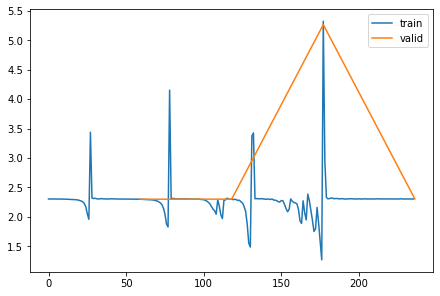

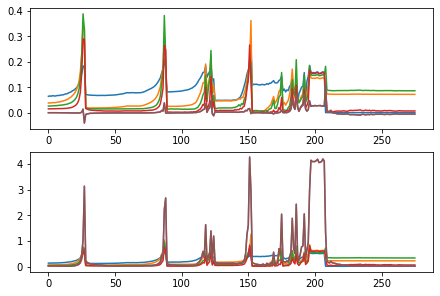

In [155]:
with Hooks(model, append_stats) as hooks:
    fit(model, epochs=4)
    fig,axs = plt.subplots(2)
    for h in hooks:
        for i in 0,1:
            axs[i].plot(h.stats[i])


In [1]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop,
                 on_train=True, on_valid=False,
                 mods=None):
        fc.store_attr()
        super().__init__()
    
    # before fit: attach the hooks by creating Hooks and 
    # passing in _hookfunc method which wraps around passed func
    def before_fit(self, learn):
        if self.mods:
            mods = self.mods
        else:
            mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))
        
    # which calls the hook func passed in in init
    def _hookfunc(self, learn, *args, **kwargs):
        if ((self.on_train and learn.training)
            or (self.on_valid and not learn.training)):
            self.hookfunc(*args, **kwargs)
    
    # calls "remove" on hooks to disattach them from model by the hooks themselves
    # are not deleted from memory, their statistics are not deleted
    def after_fit(self, learn):
        self.hooks.remove()
    
    def __iter__(self):
        return iter(self.hooks)
    def __len__(self):
        return len(self.hooks)


NameError: name 'Callback' is not defined

In [168]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

In [169]:
model=cnn()

accuracy,loss,epoch,state
0.159,2.350,0,train
0.100,2.301,0,eval


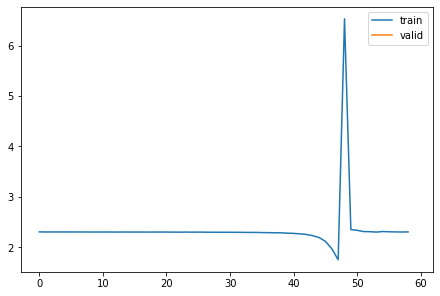

In [170]:
fit(model, xtra_cbs=[hc])

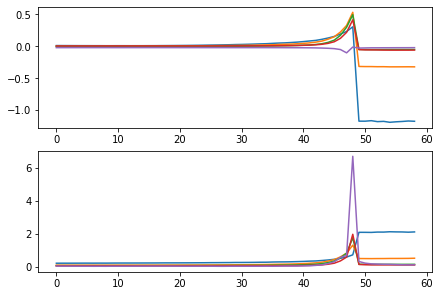

In [171]:
_,axs = plt.subplots(2)
for h in hc:
    for i in 0,1:
        axs[i].plot(h.stats[i])

In [1]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    acts = to_cpu(outp)
    if type(acts) is torch.Tensor:
        hook.stats[0].append(acts.mean())
        hook.stats[1].append(acts.std())
        hook.stats[2].append(acts.abs().histc(40,0,10))

In [185]:
t=tensor(act_means[0])
h=t.abs().histc(100,-10,10)
h.shape,h

(torch.Size([100]),
 tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0., 792.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]))

accuracy,loss,epoch,state
0.153,2.299,0,train
0.231,2.150,0,eval


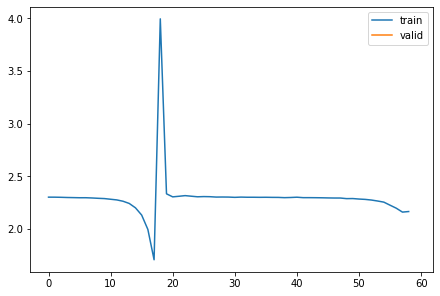

In [212]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [213]:
#| export

'''
takes log and transposes it. Since h.stats[2], the absolute
value histogram list of tensors, is basically shape 
(num_model_evaluations x num_histogram_buckets), the output
is log of (num_histogram_buckets x num_model_evals) so resultant
tensor can be visualized where rows refer to different value buckets
in the histogram and columns are activation breakdowns at 
subsequent inferences
'''
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

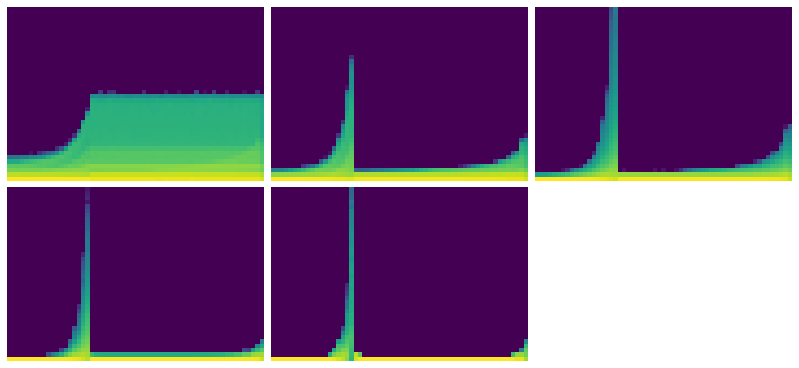

In [214]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [231]:
'''
with input size 28x28, first layer conv(1 ,8, ks=5) makes 
8 channels of a 14x14 image. 8x14x14 = 1568 activations per
image. batch size is 1024 but incomplete batch is used in last batch
so last one is different size
'''
for hook in hc:
    print(torch.stack(hook.stats[2]).t().float().sum(0)/bs)

tensor([1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568.,
        1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568.,
        1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568., 1568.,
        1568.,  931.])
tensor([784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00,
        784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00,
        784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00,
        784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 784.00, 465.50])
tensor([512.00, 512.00, 512.00, 512.00, 512.00, 5

In [232]:
#| export
'''
    over each execution, percent of activations that
    are inside lowest bucket of histogram
'''
def get_min(h):
    hists = torch.stack(h.stats[2]).t().float()

    return hists[0] / hists.sum(0)

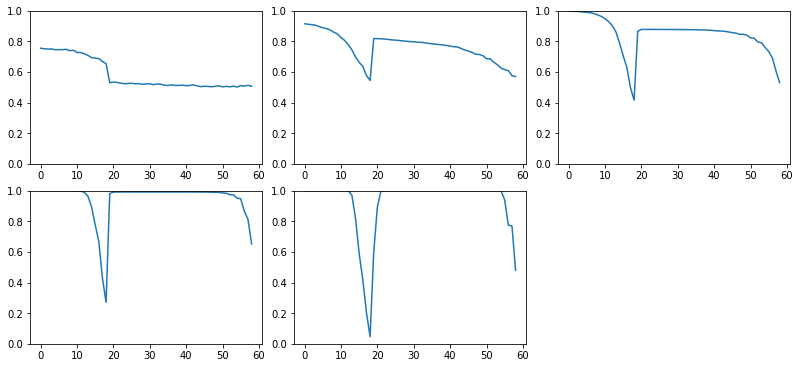

In [234]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

In [235]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [236]:
act_stats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,state
0.155,2.301,0,train
0.199,2.132,0,eval
0.338,1.863,1,train
0.536,1.177,1,eval
0.642,0.950,2,train
0.706,0.802,2,eval
0.757,0.644,3,train
0.782,0.569,3,eval
0.795,0.550,4,train
0.803,0.541,4,eval


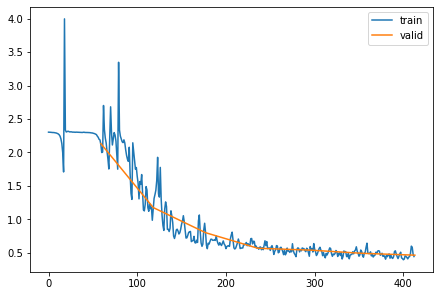

In [237]:
set_seed(1)
model=cnn()
fit(model, xtra_cbs=[act_stats], epochs=7)

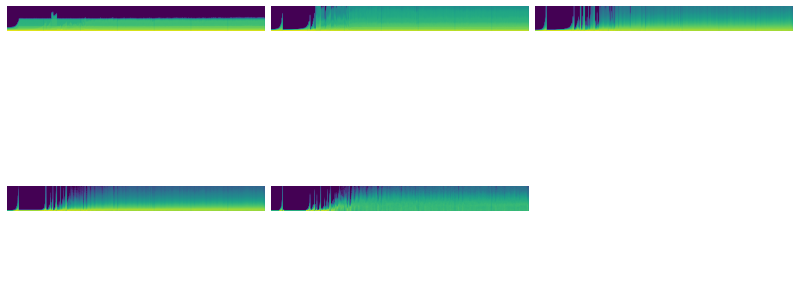

In [238]:
act_stats.color_dim()

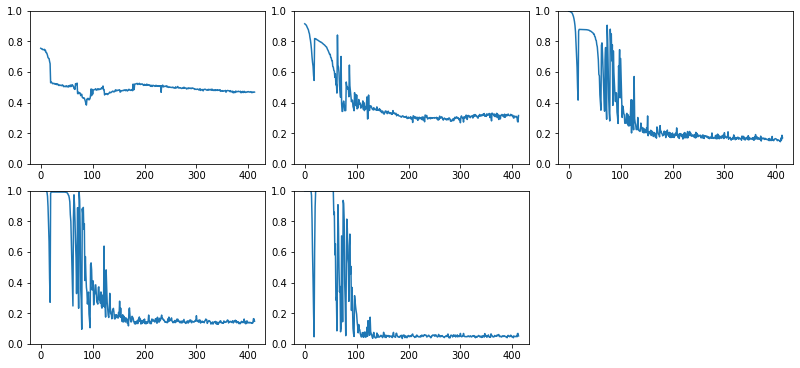

In [239]:
act_stats.dead_chart()

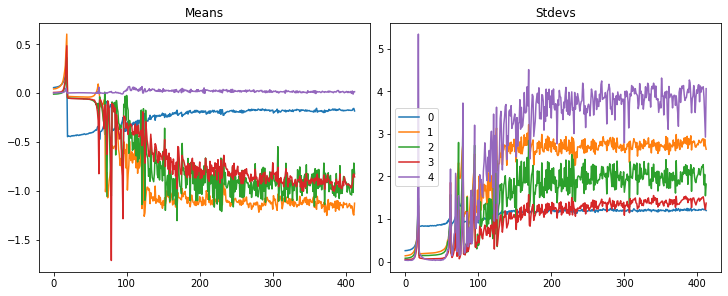

In [240]:
act_stats.plot_stats()

In [4]:
import nbdev; dir(nbdev.export)

['AttrDict',
 'BuiltinFunctionType',
 'BuiltinMethodType',
 'CollBase',
 'Config',
 'ContextManagers',
 'Dict',
 'EventTimer',
 'ExportModuleProc',
 'Float',
 'FunctionType',
 'Generator',
 'GetAttr',
 'GetAttrBase',
 'IN_COLAB',
 'IN_IPYTHON',
 'IN_JUPYTER',
 'IN_NOTEBOOK',
 'ImportEnum',
 'Inf',
 'Int',
 'IterLen',
 'Iterable',
 'Iterator',
 'L',
 'List',
 'MethodDescriptorType',
 'MethodType',
 'MethodWrapperType',
 'ModuleMaker',
 'NBProcessor',
 'NoneType',
 'NullType',
 'Optional',
 'Param',
 'PartialFormatter',
 'Path',
 'PrettyString',
 'ProcessPoolExecutor',
 'Processor',
 'ReindexCollection',
 'SCRIPT_INFO',
 'Self',
 'Sequence',
 'Set',
 'ShowPrint',
 'SimpleNamespace',
 'Stateful',
 'Str',
 'StrEnum',
 'ThreadPoolExecutor',
 'Tuple',
 'Union',
 'WrapperDescriptorType',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_magics_pattern',
 'add',
 'add_docs',
 'add_init',
 'add_one',
 'add_props',
 '